In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy

In [2]:
img = cv2.imread("./data/faces93")


In [3]:
from tqdm import tqdm

image_data = []
photos_path= "./data/faces94"
for folder in os.listdir(photos_path):
    print("going through folders")
    inside_folder_path = os.path.join(photos_path, folder)
    for images_folder in tqdm(os.listdir(inside_folder_path)):
        images_folder_path = os.path.join(inside_folder_path, images_folder)
        for image_file in filter(lambda x: x.endswith("jpg"), os.listdir(images_folder_path)):
            image_file_path = os.path.join(images_folder_path, image_file)
            image = cv2.imread(image_file_path)
            image_data.append({'Filename': image_file_path, 'ImageArray': image})

print("Created the dataframe")

going through folders


100%|██████████| 20/20 [00:01<00:00, 16.64it/s]


going through folders


100%|██████████| 113/113 [00:07<00:00, 16.09it/s]


going through folders


100%|██████████| 20/20 [00:01<00:00, 19.11it/s]

Created the dataframe


In [4]:
images = list(map(lambda item: item["ImageArray"], image_data))
files_path = list(map(lambda item: item["Filename"], image_data))
images = np.array(images)

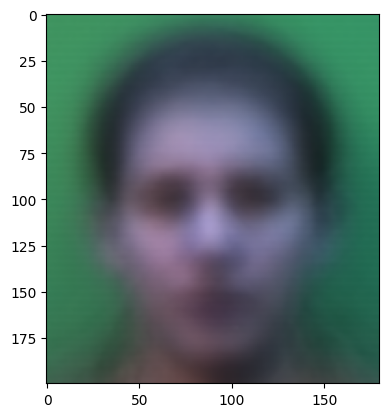

In [5]:
average_image = images.mean(axis=0)
average_image = np.round(average_image)
average_image = average_image.astype(np.uint8)
plt.imshow(average_image)

In [8]:
images_vectors_raw = images.reshape(images.shape[0], -1)
average_image = images.reshape(images.shape[0],-1).mean(axis=0)
# X = (images - average_image).reshape(images.shape[0], -1)
X = images_vectors_raw - average_image

# both of size (NxD)

In [9]:
N = images.shape[0]

In [10]:
cov_matrix = np.cov(images_vectors_raw)

### Calculate eigenfaces

In [44]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(cov_matrix, k=100)

In [162]:
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

In [ ]:
for idx in range(10):
    eigenvector = eigenvectors[:,idx]
    normalization_factor = np.sqrt(eigenvalues[idx] * N)
    eigenface1 = np.dot(X.T , eigenvector) /  normalization_factor
    eigenface_image = eigenface1.reshape(images[0].shape)
    eigenface_image = (eigenface_image - eigenface_image.min()) / (eigenface_image.max() - eigenface_image.min())
    eigenface_image = eigenface_image * 255
    eigenface_image = eigenface_image.astype(np.uint8)
    eigenface_image = cv2.cvtColor(eigenface_image, cv2.COLOR_BGR2GRAY)
    plt.imshow(eigenface_image, cmap='gray')
    plt.show()

### Transform 

In [11]:
# eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(cov_matrix)
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# for k in num_vectors:
    # image = images_vectors_raw[0]
    # image

In [12]:
normalization_factors = np.array([np.sqrt(eigenvalue * N) for eigenvalue in eigenvalues])
# eigenfaces = np.array([np.dot(X.T , eigenvectors)]) /  normalization_factors[:, np.newaxis]
eigenfaces_raw = np.array([np.dot(X.T , eigenvectors)]) # N x K

C:\Users\Ron Tohar\AppData\Local\Temp\ipykernel_15336\3852345211.py:1: RuntimeWarning: invalid value encountered in sqrt
  normalization_factors = np.array([np.sqrt(eigenvalue * N) for eigenvalue in eigenvalues])


In [14]:
eigenfaces_reshaped = np.squeeze(eigenfaces_raw)
eigenfaces_transpose = eigenfaces_reshaped / normalization_factors

In [15]:
eigenfaces = eigenfaces_transpose.T

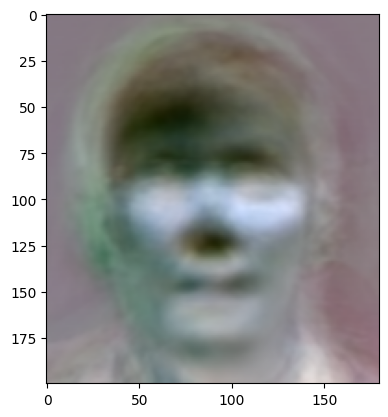

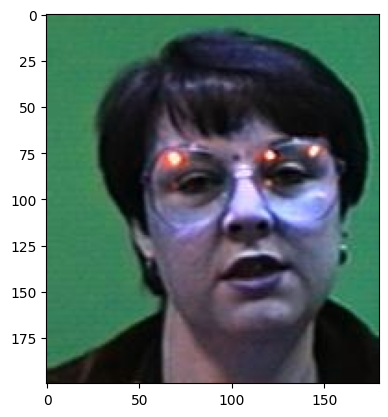

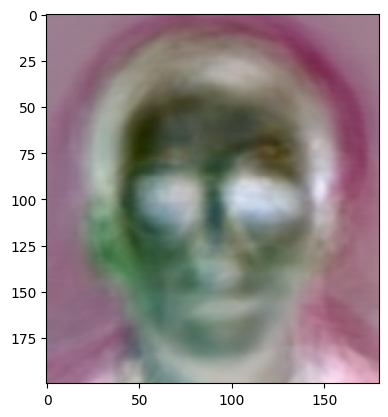

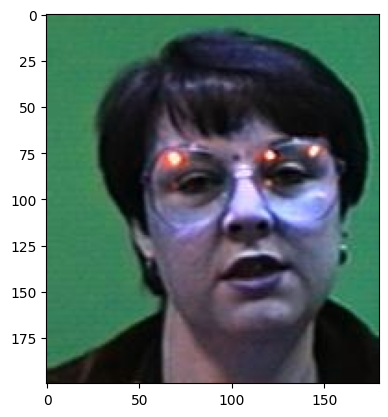

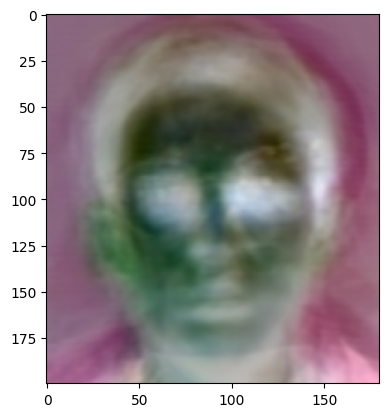

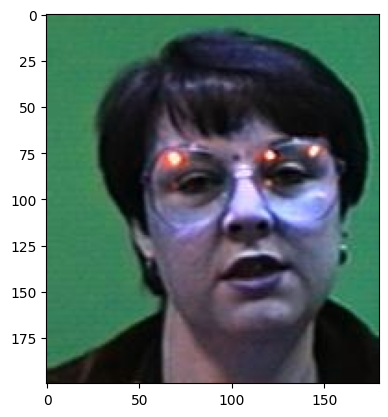

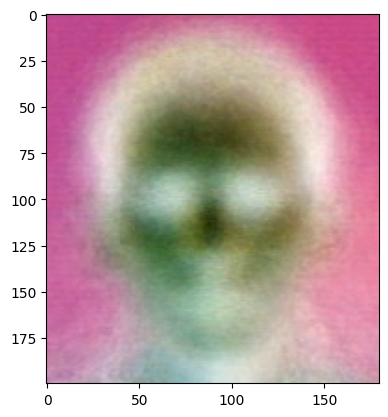

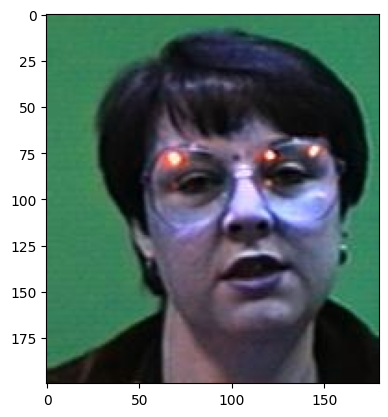

In [18]:
num_vectors = [10,20,30,3000]

def decompose_with_eigenfaces(x_n, x_avg, eigenfaces):
    coeffs = np.array([(x_n.T @ eigenface) - (x_avg.T @ eigenface) for eigenface in eigenfaces])
    eigenfaces_directions = coeffs[:,np.newaxis] * eigenfaces
    average_image_delta = sum(eigenfaces_directions)
    
    return x_avg  + average_image_delta

def show_image(image, gray=False):
    image = image.reshape(images[0].shape)
    image = (image - image.min()) / (image.max() - image.min())
    image = image * 255
    image = image.astype(np.uint8)

    if gray:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    plt.show()

for k in num_vectors:
    curr_eigenfaces = eigenfaces[:k]

    x_n = images_vectors_raw[0]
    x_avg = average_image
    new_image = decompose_with_eigenfaces(x_n, x_avg, curr_eigenfaces)
    show_image(new_image)
    show_image(x_n)

# image.shape

# images_new = np.dot(X, eigenfaces.T)

